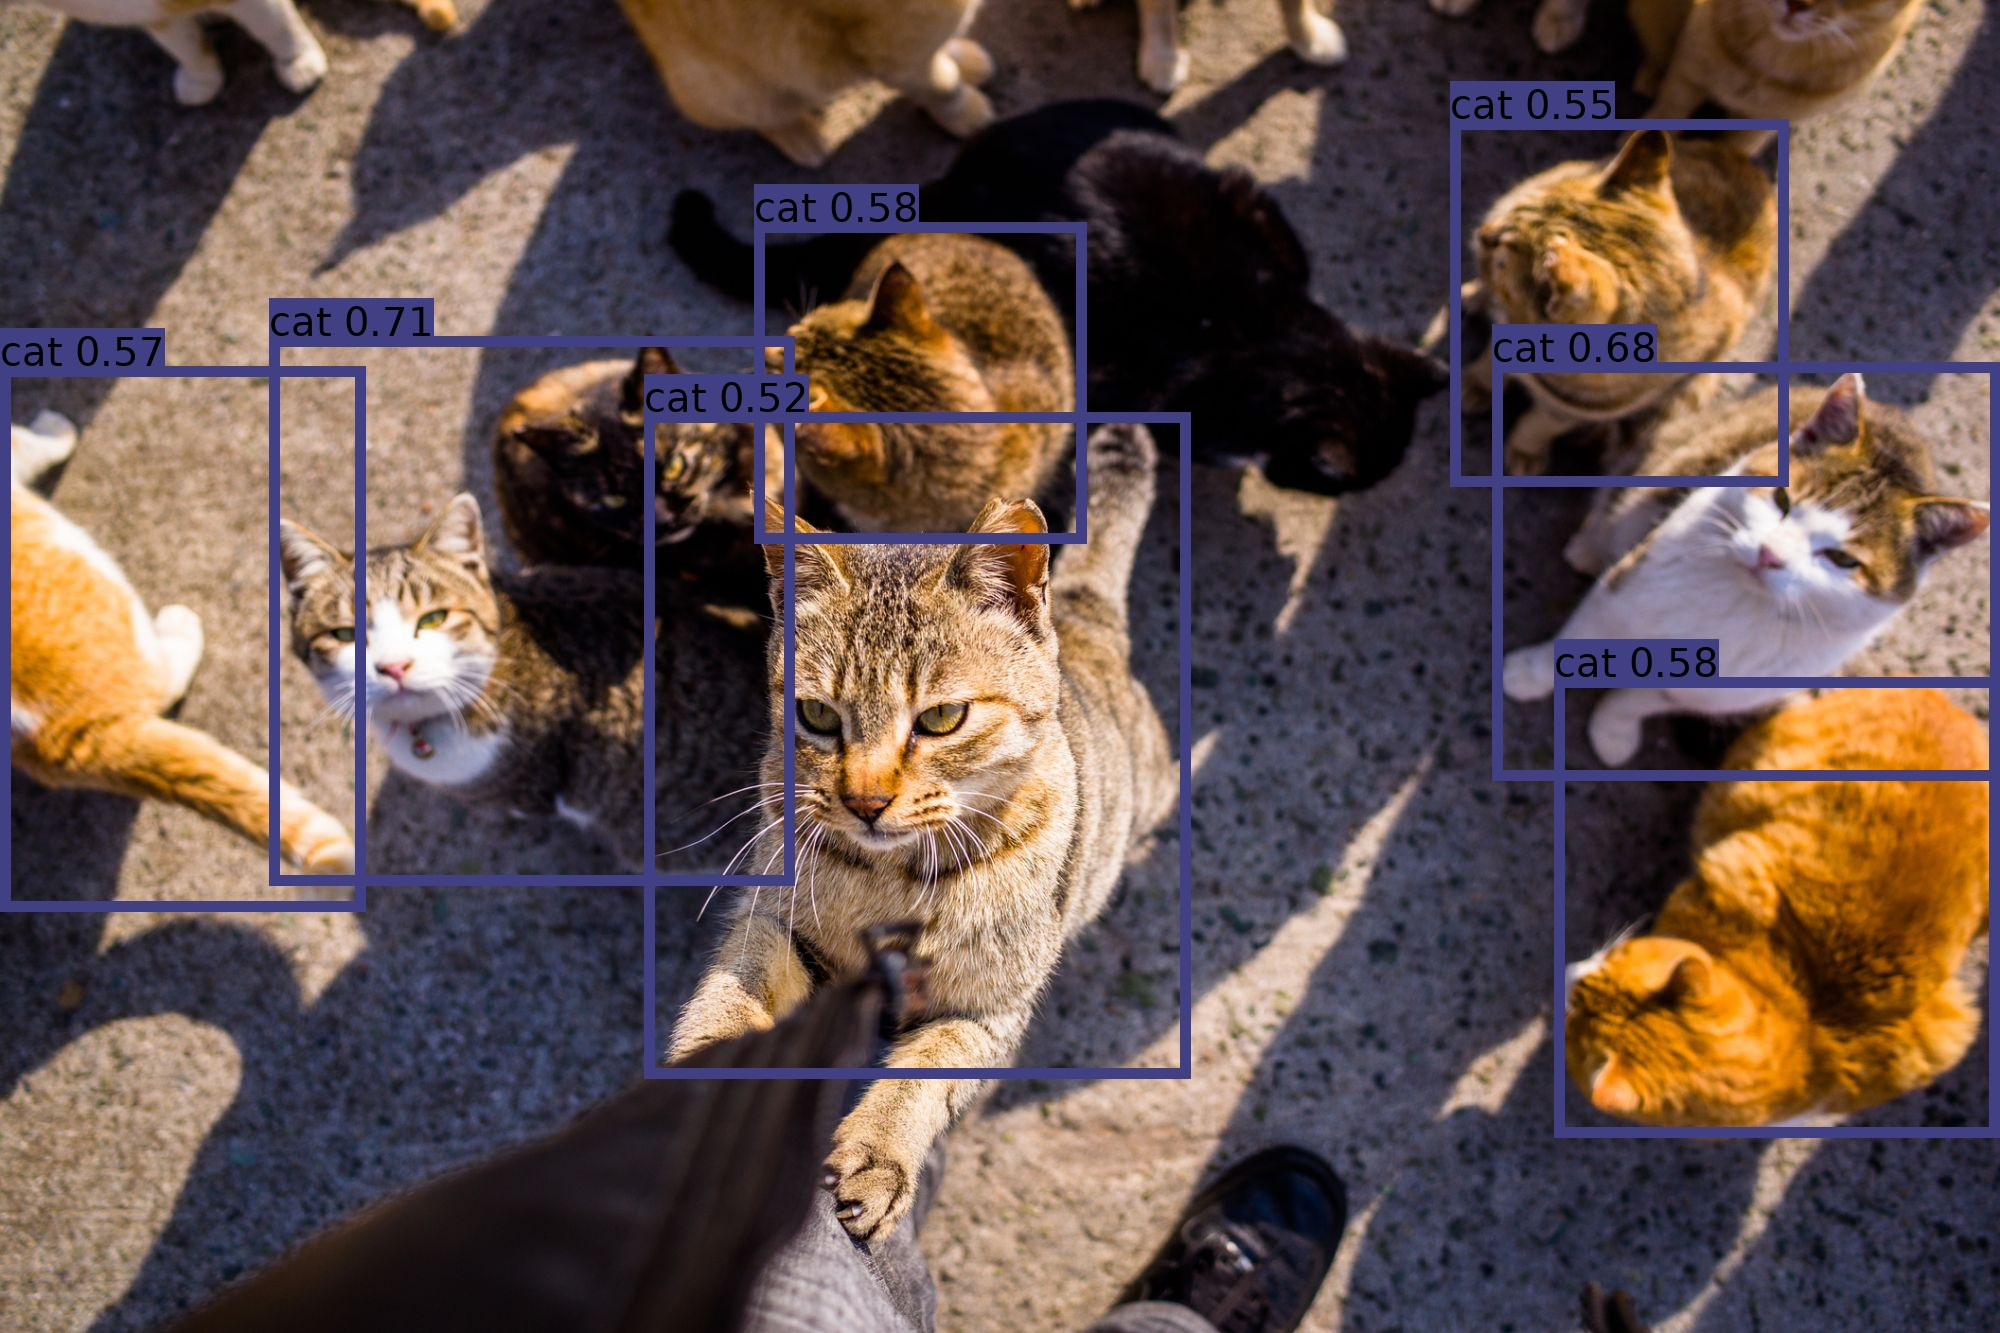

# Notebook d'inference

Ce notebook qui contient un script d'inférence est à transformer en webapp pour effectuer des prédictions.

In [2]:
import time

from PIL import Image

## Get an image

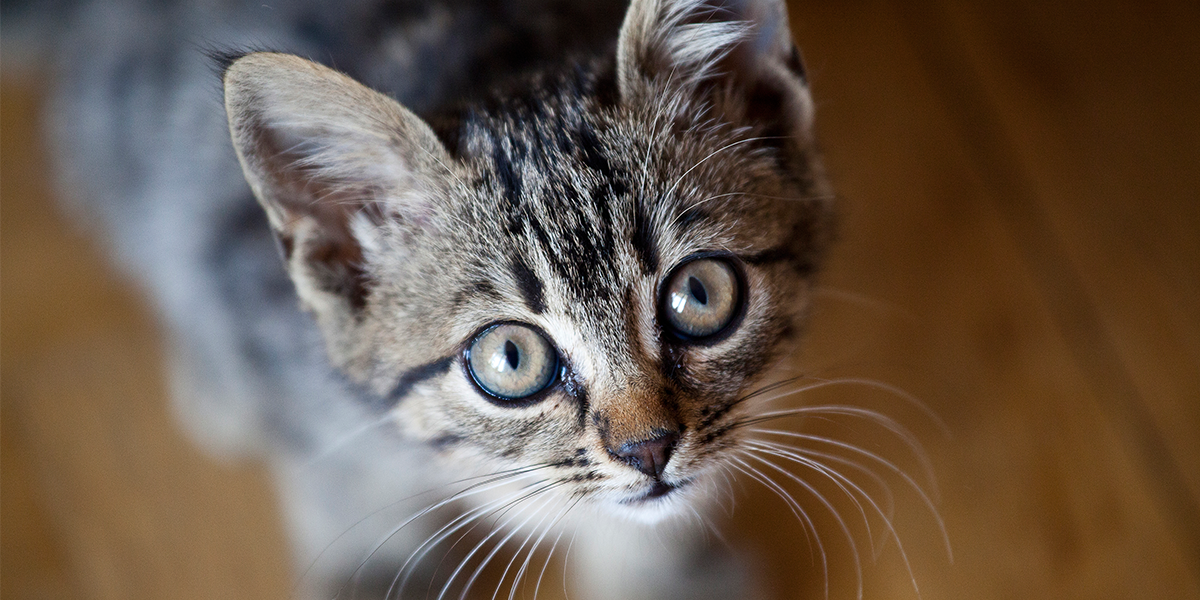

In [7]:
import base64
from io import BytesIO

import requests
from PIL import Image

response = requests.get("https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png")
img = Image.open(BytesIO(response.content))
if img.mode == "RGBA":
    img = img.convert("RGB")

img

In [11]:
# Transform the image to base64 string

buffered = BytesIO()
img.save(buffered, format="JPEG")
img_str = str(base64.b64encode(buffered.getvalue()))

## Set server URL

In [5]:
#@title Set server URL
server_url = "https://eager-states-retire-35-247-188-205.loca.lt" #@param {type:"string"}

## Select model

In [6]:
yolo_model = "yolov5m" #@param ["yolov5s", "yolov5m", "yolov5l", "yolov5x"] {allow-input: true}


## Perform the inference

In [12]:
print(type(yolo_model), yolo_model)
print(type(img_str), img_str)

<class 'str'> yolov5m
<class 'str'> b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAJYBLADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDyhkO48d6UR+2fSrTR4kPHelVOScVoZkAT8KlRPb6VIsfPIqVY8HpzTAiVQDTwuB061L5fGetLs68GgCIjnOKYRUxTnkUm2gZGFOPepkTJpyrz0qeNPamIWOPnn86txR4Pam

In [13]:
r = requests.post(f"{server_url}/predict", json={"model": yolo_model, "image": img_str})
if r.status_code == 200:
    result = r.json()
else:
    print(r.status_code)

400


In [6]:
# Inference
t0 = time.time()
predictions = model(img, size=640)  # includes NMS
t1 = time.time()
classes = predictions.names

preds = predictions.xyxy[0].numpy()

In [7]:
preds

array([[     213.06,      3.2517,       855.3,      575.31,     0.34409,          15]], dtype=float32)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import  ImageDraw, ImageFont


def draw_preds(image, preds, class_names):

    image = image.copy()

    colors = plt.cm.get_cmap("viridis", len(class_names)).colors
    colors = (colors[:, :3] * 255.0).astype(np.uint8)

    font = list(Path("/usr/share/fonts").glob("**/*.ttf"))[0].name
    font = ImageFont.truetype(font=font, size=np.floor(3e-2 * image.size[1] + 0.5).astype("int32"))
    thickness = (image.size[0] + image.size[1]) // 300

    for i in range(len(preds)):
        box = preds[i, :4]
        score = float(preds[i, 4])
        class_idx = int(preds[i, 5])
        predicted_class = class_names[class_idx]

        label = "{} {:.2f}".format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        left, top, right, bottom = box
        top = max(0, np.floor(top + 0.5).astype("int32"))
        left = max(0, np.floor(left + 0.5).astype("int32"))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype("int32"))
        right = min(image.size[0], np.floor(right + 0.5).astype("int32"))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for r in range(thickness):
            draw.rectangle([left + r, top + r, right - r, bottom - r], outline=tuple(colors[class_idx]))
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=tuple(colors[class_idx]))
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return image

In [10]:
image_with_preds = draw_preds(img, preds, classes)

cat 0.34 (213, 3) (855, 575)


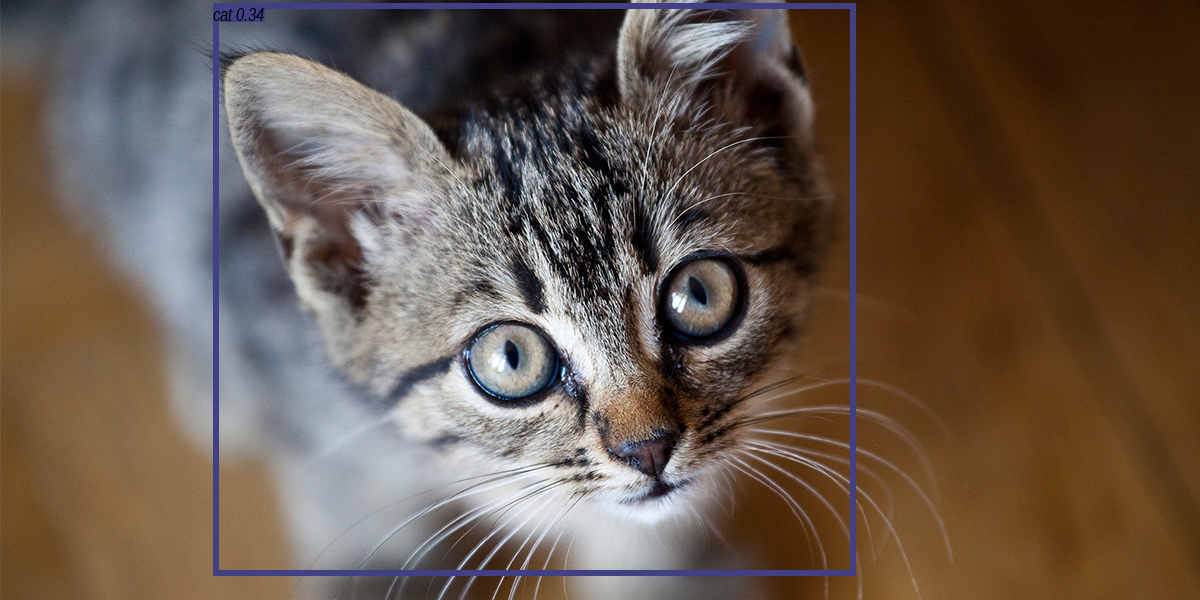

In [11]:
from IPython.display import display  # to display images

display(image_with_preds)

In [12]:
image_with_preds.save("test.png")